# <a id='toc1_'></a>[__Стохастический градиентный спуск своими руками в задаче прогнозирования продаж__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Стохастический градиентный спуск своими руками в задаче прогнозирования продаж__](#toc1_)    
  - [__Теория + advanced regression techniques__](#toc1_1_)    
  - [__Импорты и настройки__](#toc1_2_)    
  - [__Фабула__](#toc1_3_)    
  - [__Обзор данных__](#toc1_4_)    
  - [__Подготовка данных: масштабирование, добавление константного признака__](#toc1_5_)    
  - [__Среднеквадратичная ошибка на медианном предсказании__](#toc1_6_)    
  - [__Аналитическое решение с помощью нормального уравнения линейной регрессии__](#toc1_7_)    
  - [__Решение с помощью стохастического градиентного спуска__](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Теория + advanced regression techniques__](#toc0_)

[__ml_linreg.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_linreg/ml_linreg.ipynb)

***
## <a id='toc1_2_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# сторонние библиотеки
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.descriptivestats import describe
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
# разрешение графиков по умолчанию
matplotlib.rcParams['figure.dpi'] = 400

In [3]:
# составные типы данных
scalar = int | float
vector = np.ndarray | pd.Series

***
## <a id='toc1_3_'></a>[__Фабула__](#toc0_)

Прогнозирование продаж компании в зависимости от уровня ее инвестиций в рекламу в различных СМИ.

***
## <a id='toc1_4_'></a>[__Обзор данных__](#toc0_)

In [4]:
# первые пять строк датасета
data = pd.read_csv('advertising.csv')
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [5]:
# случайная выборка из десяти наблюдений
data.sample(10)

,TV,Radio,Newspaper,Sales
122,18.8,21.7,50.4,7.0
89,88.3,25.5,73.4,12.9
78,120.5,28.5,14.2,14.2
189,286.0,13.9,3.7,15.9
50,66.9,11.7,36.8,9.7
145,96.2,14.8,38.9,11.4
61,53.5,2.0,21.4,8.1
180,165.6,10.0,17.6,12.6
115,78.2,46.8,34.5,14.6
3,17.2,45.9,69.3,9.3


In [6]:
# полнота данных и типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


[__pandas.DataFrame.describe__](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas-dataframe-describe)

> Generate descriptive statistics.

In [7]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


[__statsmodels.stats.descriptivestats.describe__](https://www.statsmodels.org/dev/generated/statsmodels.stats.descriptivestats.describe.html#statsmodels-stats-descriptivestats-describe)

> Extended descriptive statistics for data.

In [8]:
descr = describe(data)
descr

,TV,Radio,Newspaper,Sales
nobs,200.000000,200.000000,2.000000e+02,200.000000
missing,0.000000,0.000000,0.000000e+00,0.000000
mean,147.042500,23.264000,3.055400e+01,14.022500
std_err,6.070811,1.049828,1.539981e+00,0.368930
upper_ci,158.941071,25.321625,3.357231e+01,14.745589
lower_ci,135.143929,21.206375,2.753569e+01,13.299411
std,85.854236,14.846809,2.177862e+01,5.217457
iqr,144.450000,26.550000,3.235000e+01,7.025000
iqr_normal,107.080945,19.681544,2.398109e+01,5.207640
mad,75.104650,12.969000,1.763548e+01,4.279975


***
## <a id='toc1_5_'></a>[__Подготовка данных: масштабирование, добавление константного признака__](#toc0_)

In [9]:
predictors = data.columns[:3]
X = data[predictors].values
y = data.Sales.values  # целевая переменная - продажи

In [10]:
# вывод: statsmodels, как и pandas, по умолчанию дает НЕсмещенные оценки
descr.loc[['mean', 'std']][predictors]

,TV,Radio,Newspaper
mean,147.042500,23.264000,30.554000
std,85.854236,14.846809,21.778621


In [11]:
scaler = StandardScaler(copy=False)  # не копируем для inplace scaling
scaler.fit_transform(X)  # масштабирование признаков

array([[ 9.69852266e-01,  9.81522472e-01,  1.77894547e+00],
       [-1.19737623e+00,  1.08280781e+00,  6.69578760e-01],
       [-1.51615499e+00,  1.52846331e+00,  1.78354865e+00],
       [ 5.20496822e-02,  1.21785493e+00,  1.28640506e+00],
       [ 3.94182198e-01, -8.41613655e-01,  1.28180188e+00],
       [-1.61540845e+00,  1.73103399e+00,  2.04592999e+00],
       [-1.04557682e+00,  6.43904671e-01, -3.24708413e-01],
       [-3.13436589e-01, -2.47406325e-01, -8.72486994e-01],
       [-1.61657614e+00, -1.42906863e+00, -1.36042422e+00],
       [ 6.16042873e-01, -1.39530685e+00, -4.30581584e-01],
       [-9.45155670e-01, -1.17923146e+00, -2.92486143e-01],
       [ 7.90028350e-01,  4.96973404e-02, -1.22232878e+00],
       [-1.43908760e+00,  7.99208859e-01,  1.62704048e+00],
       [-5.78501712e-01, -1.05768905e+00, -1.07502697e+00],
       [ 6.66253447e-01,  6.50657027e-01,  7.11007392e-01],
       [ 5.64664612e-01,  1.65000572e+00,  1.02862691e+00],
       [-9.25304978e-01,  9.00494200e-01

In [12]:
# вывод: scikit-learn, как и numpy, по умолчанию дает смещенные оценки (ddof=0)
np.std(data[predictors])

TV           85.639332
Radio        14.809646
Newspaper    21.724106
dtype: float64

In [13]:
np.std(data[predictors], ddof=1)  # сравни с pandas выше

TV           85.854236
Radio        14.846809
Newspaper    21.778621
dtype: float64

In [14]:
X = sm.add_constant(X)  # добавление константного признака

***
## <a id='toc1_6_'></a>[__Среднеквадратичная ошибка на медианном предсказании__](#toc0_)

In [15]:
def mserror(y_true: scalar | vector, y_pred: scalar | vector) -> float:
    """
    Среднеквадратичная ошибка прогноза. 
    """
    return np.mean(np.square(y_true - y_pred))

Посмотрим, какой будет среднеквадратичная ошибка прогноза __`Sales`__, если всегда предсказывать медианное значение по исходной выборке:

In [16]:
# sklearn.metrics.mean_squared_error ожидает array-like, не скаляр
y_pred = np.full((y.size,), descr.loc['median'].Sales)

for func in mserror, mse:
    print(f'{func.__name__}: {func(y, y_pred):.3f}')

mserror: 28.346
mean_squared_error: 28.346


***
## <a id='toc1_7_'></a>[__Аналитическое решение с помощью нормального уравнения линейной регрессии__](#toc0_)

Нахождение вектора оптимальных весов $w$ может быть сделано и аналитически.
Мы хотим найти такой вектор весов $w$, чтобы вектор $y$, приближающий целевой признак, получался умножением матрицы $X$, состоящей из всех признаков объектов обучающей выборки, кроме целевого, на вектор весов $w$. То есть чтобы выполнялось матричное уравнение:
$$\large y = Xw$$
Домножением слева на $X^T$ получаем:
$$\large X^Ty = X^TXw$$
Это хорошо, поскольку теперь матрица $X^TX$ — квадратная, и можно найти решение, вектор $w$, в виде:
$$\large w = {(X^TX)}^{-1}X^Ty$$
Матрица ${(X^TX)}^{-1}X^T$ - [__псевдообратная__](https://ru.wikipedia.org/wiki/Псевдообратная_матрица) для матрицы $X$.

[__numpy.linalg.pinv__](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html#numpy-linalg-pinv)

> Compute the (Moore-Penrose) pseudo-inverse of a matrix.

Однако нахождение псевдообратной матрицы операция вычислительно сложная и нестабильная в случае малого определителя матрицы $X$ (проблема мультиколлинеарности). На практике лучше находить вектор весов $w$ решением матричного уравнения 
$$\large X^TXw = X^Ty$$

[__numpy.linalg.solve__](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html#numpy-linalg-solve)

> Solve a linear matrix equation, or system of linear scalar equations.

In [17]:
def normal_equation(X: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Аналитическое решение с помощью нормального уравнения линейной регрессии. 
    """
    return np.linalg.inv(X.T @ X) @ X.T @ target

In [18]:
norm_eq_weights = normal_equation(X, y)
norm_eq_weights

array([14.0225    ,  3.91925365,  2.79206274, -0.02253861])

In [19]:
sm.OLS(y, X).fit().params  # OK!

array([14.0225    ,  3.91925365,  2.79206274, -0.02253861])

Посчитаем среднеквадратичную ошибку прогноза продаж, сделанного линейной моделью с весами, найденными с помощью нормального уравнения:

In [20]:
def linear_prediction(X: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """
    Предсказание линейной модели. 
    """
    return X @ weights

In [21]:
err = mserror(y, linear_prediction(X, norm_eq_weights))
err

2.784126314510936

***
## <a id='toc1_8_'></a>[__Решение с помощью стохастического градиентного спуска__](#toc0_)

На практике для больших матриц $X$ быстрее работает градиентный спуск, особенно его стохастическая версия.

Мы работаем с выборкой, содержащей 3 признака. Для настройки параметров (весов) модели решается следующая задача:
$$\large \frac{1}{\ell}\sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}^2} \rightarrow \min_{w_0, w_1, w_2, w_3},$$
где $x_{i1}, x_{i2}, x_{i3}$ — значения признаков $i$-ого объекта, $y_i$ — значение целевого признака $i$-ого объекта, $\ell$ — число объектов в обучающей выборке.

Параметры $w_0, w_1, w_2, w_3$, по которым минимизируется среднеквадратичная ошибка, можно находить численно с помощью градиентного спуска.
Градиентный шаг для весов выглядит так:

$$\large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

$$\large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}},$$

где $j \in \{1,2,3\}, \; \eta$ — параметр, шаг градиентного спуска, скорость обучения, или learning rate.

Проблема градиентного спуска в том, что на больших выборках считать на каждом шаге градиент по всем имеющимся данным может быть очень вычислительно затратно. 
В __стохастическом варианте__ градиентного спуска поправки для весов вычисляются только с учетом одного случайно взятого объекта обучающей выборки:

$$\large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$

$$\large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},$$
где $j \in \{1,2,3\}, \; k$ — случайный индекс, $k \in \{1, \ldots, \ell\}$.

[__numpy.linalg.norm__](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy-linalg-norm)

> Matrix or vector norm.

In [22]:
def sgd_step(X, target, weights, i, lrate):
    """
    Шаг стохастического градиентного спуска (итерация обновления весов),
    выполненный на случайном i-ом объекте обучающей выборки. 
    """
    return weights - 2 * lrate * X[i] * (X[i] @ weights - target[i]) / X.shape[0]

In [23]:
def sgd(
    X, target, *, w_init, lrate=1e-2, max_iter=1e5, eps=1e-8, seed=42
) -> tuple[np.ndarray, list[float]]:
    """
    Веса линейной модели с помощью стохастического градиентного спуска.
    Среднеквадратичная ошибка на каждой итерации градиентного спуска.
    """
    weights, w_norm = w_init, np.inf
    step, errors = 0, []
    rng = np.random.default_rng(seed)

    while w_norm >= eps and step < max_iter:
        index = rng.integers(X.shape[0])
        weights = sgd_step(X, target, weights, index, lrate)
        w_norm = np.linalg.norm(weights)
        errors.append(mserror(target, linear_prediction(X, weights)))
        step += 1
    
    return weights, errors

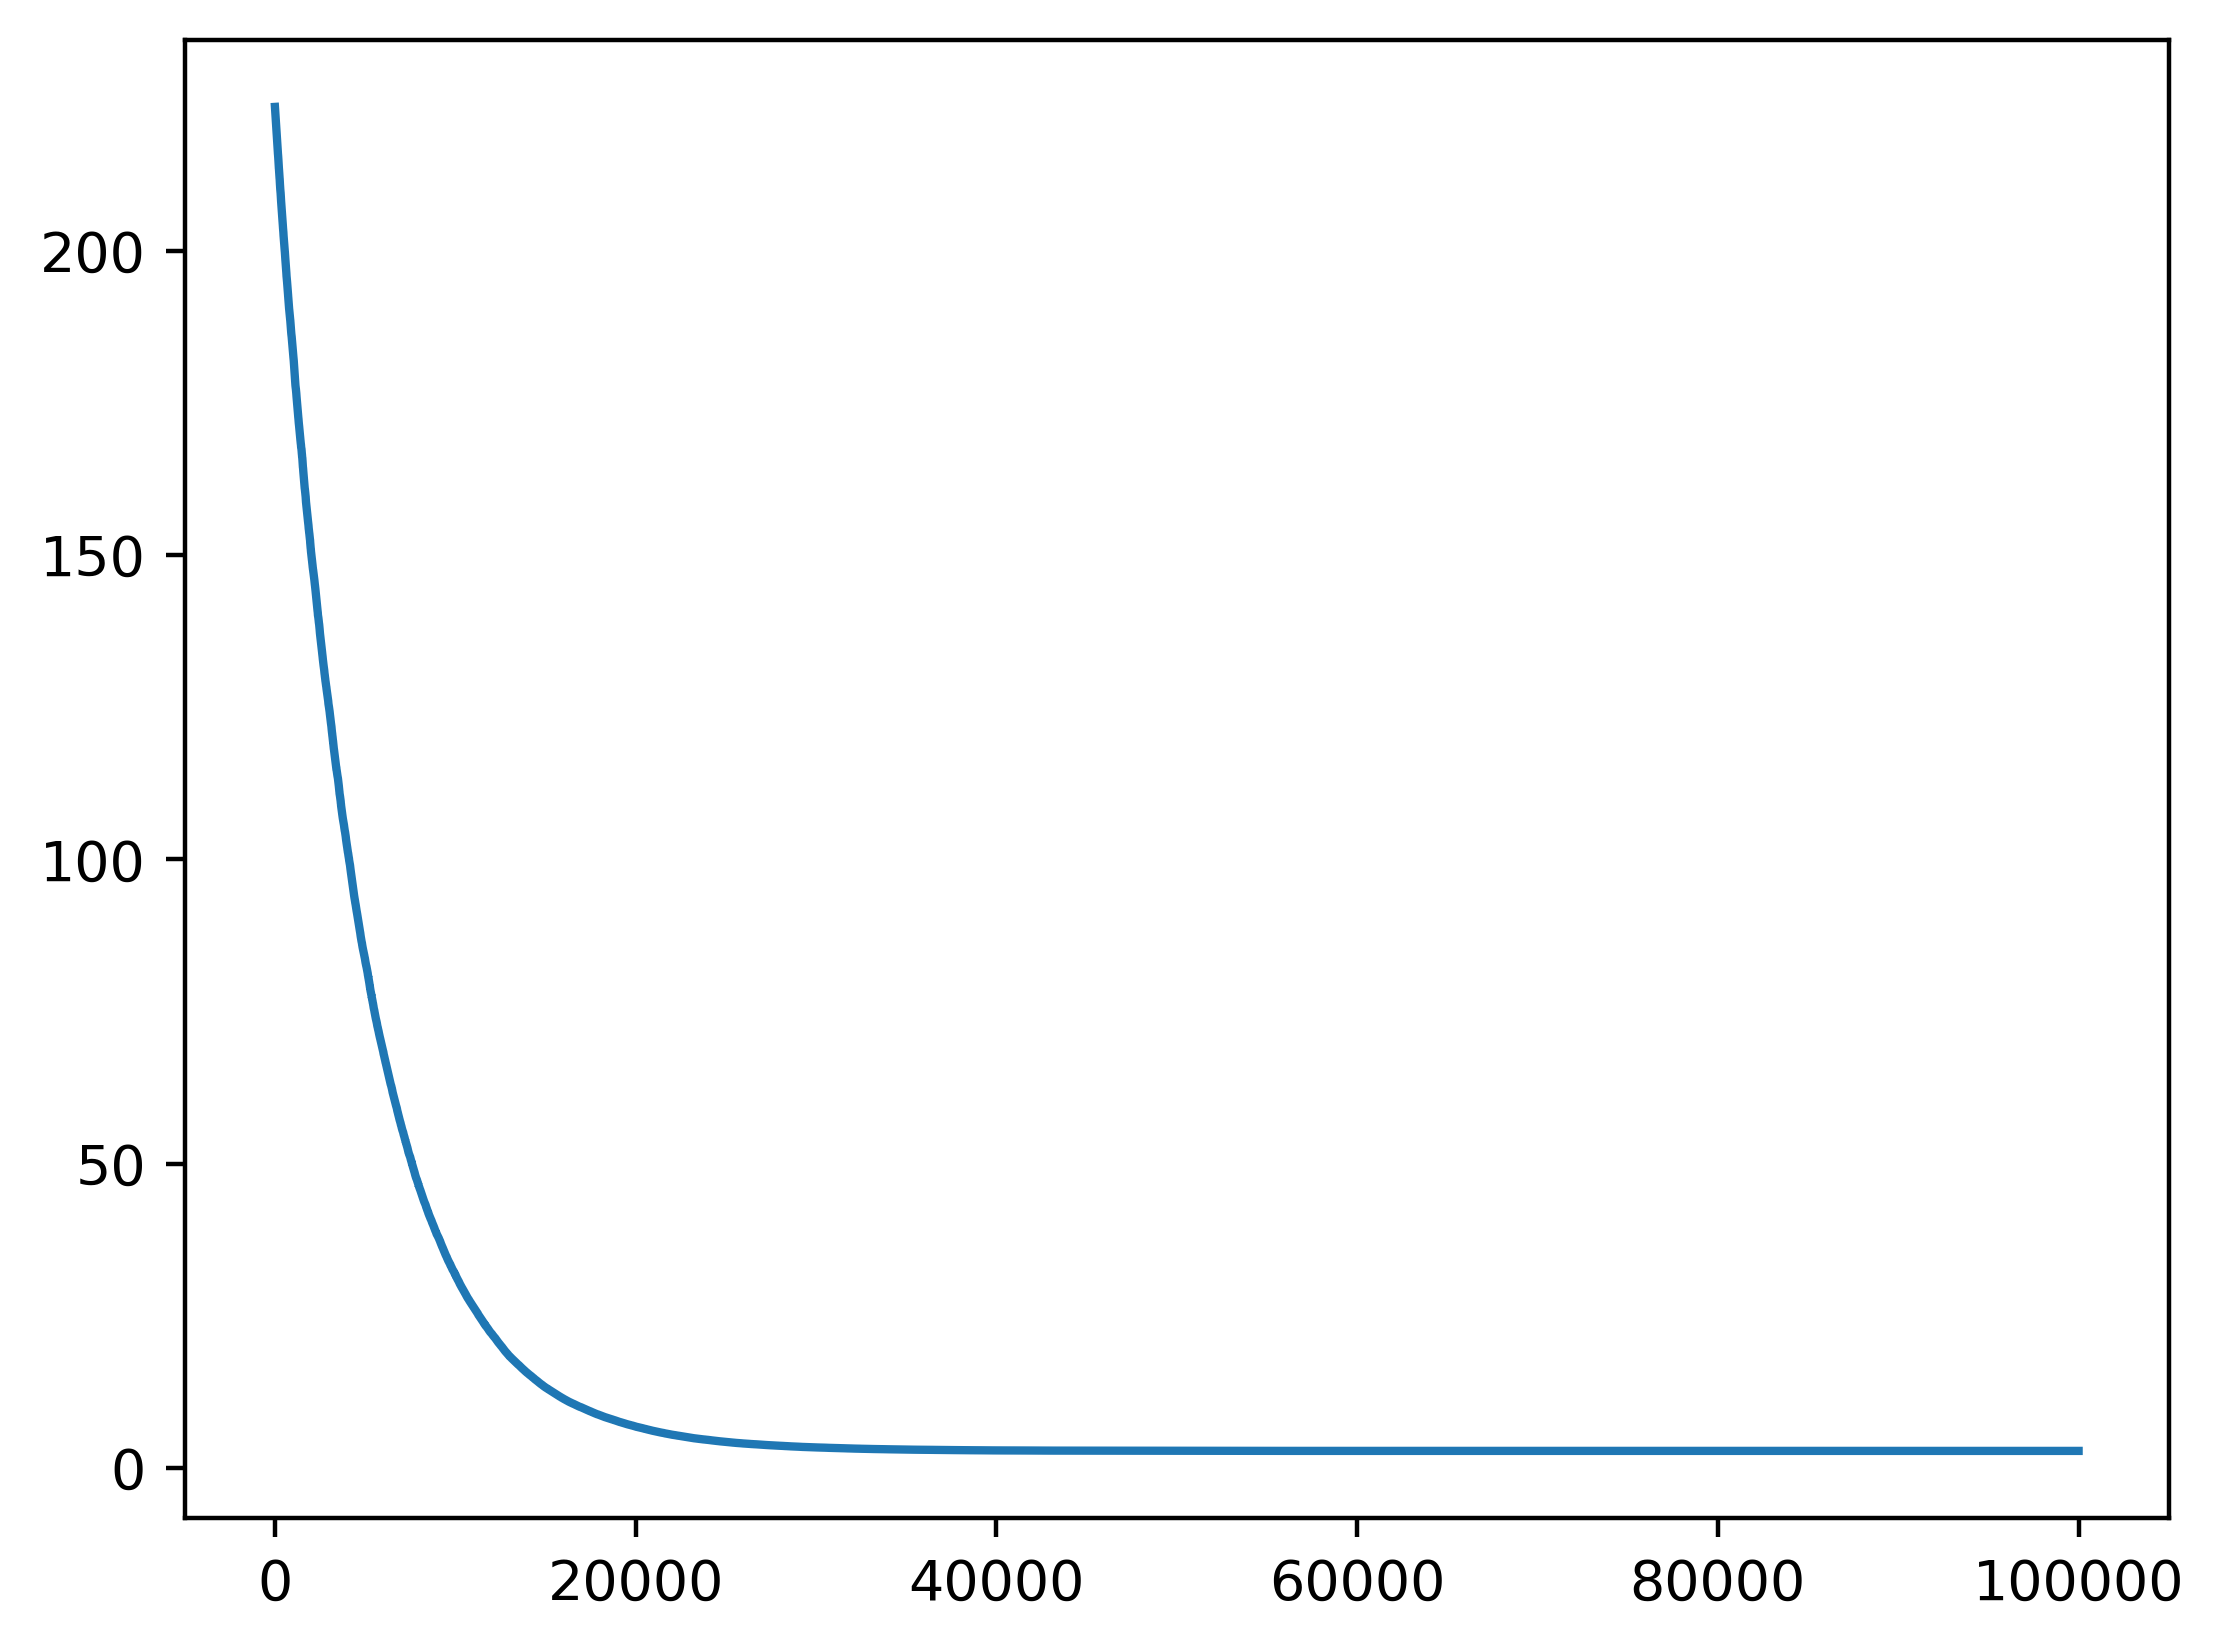

In [24]:
weights, errors = sgd(X, y, w_init=np.zeros(4))

plt.plot(errors)
plt.show()

In [25]:
# итоговые веса по окончании спуска
weights

array([14.02874014,  3.90489666,  2.79828303, -0.0388687 ])

In [26]:
# значение среднеквадратичной ошибки на последней итерации спуска
errors[-1]

2.7846215756579977

In [27]:
# расхождение ошибок в аналитическом и градиентном решениях
abs(errors[-1] - err)

0.0004952611470616652

На большом масштабе графика выше не видны скачки значений ошибки. Показать, что ошибка не всегда уменьшается, можно так: 

[__pandas.Series.is_monotonic_decreasing__](https://pandas.pydata.org/docs/reference/api/pandas.Series.is_monotonic_decreasing.html#pandas-series-is-monotonic-decreasing)

> Return boolean if values in the object are monotonically decreasing.

In [28]:
pd.Series(errors).is_monotonic_decreasing

False

***